In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import pickle
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
import math
import matplotlib.patches as mpatches

from collections import defaultdict
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
def get_ens(outcar):
    errs = []
    
    with open(outcar, "r") as f:
        lines = f.readlines()
    
    for idx, line in enumerate(lines):
        if "BEEFens" in line:
            relevant_idx = idx+1
    for line in lines[relevant_idx:relevant_idx+2000]:
        errs.append(float(line))
    return np.asarray(errs)

h2_ens = get_ens("/home/michael/ref_beef_calcs/H2/OUTCAR")
h2o_ens = get_ens("/home/michael/ref_beef_calcs/H2O/OUTCAR")

finished_outcars = pickle.load(open("/home/michael/PycharmProjects/gaussian_job_manage/finished_vasps.p", "rb"))

finished_vacs = finished_outcars[::3]
finished_ohs = finished_outcars[1::3]
finished_oohs = finished_outcars[2::3]

bad_catalysts = ["Ni_32a_32", "Ni_3a1_10", "Co_3a1_9_", "Fe_31a_11", "Ni_oct_desorbed_4_", "Co_31a_9_" 
                "Cr_32a_33", "Cr_32a_35", "Co_3a1_11", "Ni_31a_9_", "Co_3a1_7_", "Cr_31a_16", "Fe_3a1_11",
                "Cr_3a1_27", "Fe_31a_9_", "Mn_31a_12", "Ni_31a_11", "Ni_31a_10", "Mn_3a1_18", "Cr_3a1_16", 
                 "Mn_3a1_15", "Cr_31a_17", "Cr_32a_33", "Cr_3a1_3_", "Cr_31a_8_", "Cr_3a1_9_", "Cr_3a1_8_"]

catalyst2ens_errors = defaultdict(float)
catalyst2angles = defaultdict(float)
catalyst2ratio = defaultdict(float)
catalys2oh_ens = defaultdict()
catalys2ooh_ens = defaultdict()
catalys2oh_err = defaultdict()
catalys2ooh_err = defaultdict()

for v, oh, ooh in zip(finished_vacs, finished_ohs, finished_oohs):    
    if "lorbit_add" in v:
        name = v.split("/")[4]
    else:
        name = v.split("/")[5]
    if name in bad_catalysts or "penta" in name:
        continue
    catname = v.split("/")[5]
    vac_ens = get_ens(v)
    oh_ens = get_ens(oh)
    ooh_ens = get_ens(ooh)
    
    oh_err = np.std(oh_ens-vac_ens-h2o_ens+0.5*h2_ens)
    ooh_err = np.std(ooh_ens-vac_ens-2*h2o_ens+1.5*h2_ens)
    total_oh_ens = oh_ens-vac_ens-h2o_ens+0.5*h2_ens
    total_ooh_ens = ooh_ens-vac_ens-2*h2o_ens+1.5*h2_ens
    
    within_range_ooh = []
    within_range_oh = []
    for idx, x in enumerate(total_ooh_ens):
        if abs(x)<ooh_err and total_oh_ens[idx]<oh_err:
            within_range_ooh.append(x)
            within_range_oh.append(total_oh_ens[idx])
    catalys2oh_ens[catname] = within_range_oh
    catalys2oh_err[catname] = oh_err
    
    catalys2ooh_ens[catname] = within_range_ooh
    catalys2ooh_err[catname] = ooh_err


In [3]:
charged_cats = []
for v in finished_vacs:
    with open(v.replace("OUTCAR", "INCAR"), "r") as f:
        lines = f.readlines()
    
#     for line in lines:
#         if "NELECT" in line:
#             find = True
#             charged_cats.append(v.split("/")[5])
#             break
    

In [4]:
label2metal = {
    "#404040": "Cr",
    "#4CC3D9": "Co",
    "#7BC8A4": "Ni",
    "#FFC65D": "Mn",
    "#93648D": "Ru", 
    "#F16745": "Fe"
}

LinregressResult(slope=0.9067205024327719, intercept=3.29179935419211, rvalue=0.9669314754817905, pvalue=3.964199323667096e-111, stderr=0.017630752575072475)
186


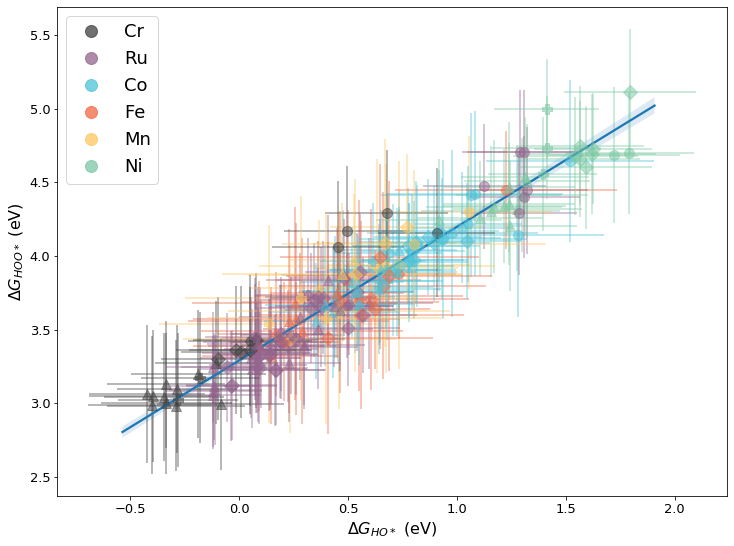

In [5]:

from matplotlib.patches import Patch, Circle
custom_lgd = [
    Line2D(range(1), range(1),label='Cr',marker='o', color='#404040', lw=0, markersize=12, alpha=0.75),
    Line2D(range(1), range(1),label='Ru',marker='o', color='#93648D', lw=0, markersize=12,alpha=0.75),
    Line2D(range(1), range(1), label='Co',marker='o', color='#4CC3D9', lw=0, markersize=12,alpha=0.75),
    Line2D(range(1), range(1),label='Fe',marker='o', color='#F16745', lw=0, markersize=12,alpha=0.75),
    Line2D(range(1), range(1),label='Mn',marker='o', color='#FFC65D', lw=0, markersize=12,alpha=0.75),
    Line2D(range(1), range(1),label='Ni',marker='o', color='#7BC8A4', lw=0, markersize=12,alpha=0.75),
]

fig, ax = plt.subplots(figsize=(12,9))

ele2color = {
    "Fe": "#F16745",
    "Co": "#4CC3D9",
    "Mn": "#FFC65D",
    "Cr": "#404040",
    "Ru": "#93648D",
    "Ni": "#7BC8A4"
}

geom2shape = {
    "31a": "D",
    "3a1": "^",
    "oct_desorbed": "o",
    "32a": "P",
    "hexa": "v",
    "41a": "H"
}

data = pickle.load(open("/home/michael/PycharmProjects/gaussian_job_manage/vasp_data.p", 'rb'))

catnames = []
oh_values = []
ooh_values = []

for name in data:
    if "pbp" in name or "penta" in name:
        continue
    #Dont consider these catalysts
    if name in bad_catalysts or "penta" in name:
        continue
        
    catnames.append(name)
    oh_values.append(data[name][0])
    ooh_values.append(data[name][1])

sns.regplot(oh_values, ooh_values, scatter_kws={'color':'w'})
for name, oh_val, ooh_val in zip(catnames, oh_values, ooh_values):

    color = ele2color[name[:2]]
    for key in geom2shape:
        if key in name:
            marker = geom2shape[key]

    #plt.plot(oh_val, ooh_val, alpha=0.5, color=color, marker=marker, markersize=10)
    plt.errorbar(oh_val, ooh_val, xerr=catalys2oh_err[name], yerr=catalys2ooh_err[name],
                 alpha=0.5, color=color, marker=marker, markersize=10)

#plt.axis('equal')
from scipy.stats import linregress
print(linregress(oh_values, ooh_values))
#plt.plot(1.23, 3.69, marker='*')
ax.legend(handles=custom_lgd, fontsize=18)
plt.xlabel("$\Delta{G_{HO*}}$ (eV)", fontsize=16)
plt.ylabel("$\Delta{G_{HOO*}}$ (eV)", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
print(len(oh_values))
plt.savefig("beef_datapoints.pdf")

In [6]:
linregress(oh_values, ooh_values)

LinregressResult(slope=0.9067205024327719, intercept=3.29179935419211, rvalue=0.9669314754817905, pvalue=3.964199323667096e-111, stderr=0.017630752575072475)

In [7]:
import matplotlib.tri as tri

metal_to_x_vec = defaultdict(list)
metal_to_y_vec = defaultdict(list)

for name, oh_val, ooh_val in zip(catnames, oh_values, ooh_values):
    #plt.plot(np.asaray(catalys2oh_ens[name])+oh_val, np.asarray(catalys2ooh_ens[name])+ooh_val,
    metal_to_x_vec[name[:2]].append(list(np.asarray(catalys2oh_ens[name])+oh_val)[:1000])
    metal_to_y_vec[name[:2]].append(list(np.asarray(catalys2ooh_ens[name])+ooh_val)[:1000])

for key in metal_to_x_vec:
    metal_to_x_vec[key] = [x for y in metal_to_x_vec[key] for  x in y]
    metal_to_y_vec[key] = [x for y in metal_to_y_vec[key] for  x in y]



In [8]:
label2metal = {
    "#404040": "Cr",
    "#4CC3D9": "Co",
    "#7BC8A4": "Ni",
    "#FFC65D": "Mn",
    "#93648D": "Ru", 
    "#F16745": "Fe"
}

from matplotlib.legend_handler import HandlerPatch
colors = ["g", "w"]
texts = ["Green Data Description", "RedData Description"]
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=height + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

metals = ["Cr", "Co", "Ni", "Mn", "Ru", "Fe"]
c = [ mpatches.Circle((0.5, 0.5), radius=0.25, facecolor=ele2color[i], edgecolor="none" ) for i in metals]
#plt.legend(c,texts, ncol=2, handler_map={mpatches.Circle: HandlerEllipse()})


In [9]:
count= 0
for n in catnames:
    if "Co" in n:
        count+=1
        print(n)
        
print(count)

Co_31a_23
Co_3a1_17
Co_3a1_2_
Co_31a_30
Co_31a_14
Co_32a_35
Co_3a1_24
Co_31a_6_
Co_oct_desorbed_2_
Co_32a_31
Co_3a1_3_
Co_3a1_30
Co_31a_15
Co_oct_desorbed_4_
Co_oct_desorbed_6_
Co_oct_desorbed_5_
Co_3a1_29
Co_3a1_10
Co_3a1_19
Co_31a_17
Co_41a_1_
Co_oct_desorbed_3_
Co_31a_5_
Co_32a_32
Co_3a1_25
Co_32a_33
Co_3a1_5_
Co_31a_19
Co_41a_2_
Co_31a_3_
Co_32a_34
Co_3a1_1_
Co_31a_9_
Co_3a1_20
Co_31a_20
Co_31a_24
Co_3a1_27
Co_3a1_13
Co_31a_26
Co_31a_18
Co_3a1_26
Co_3a1_22
Co_oct_desorbed_1_
43


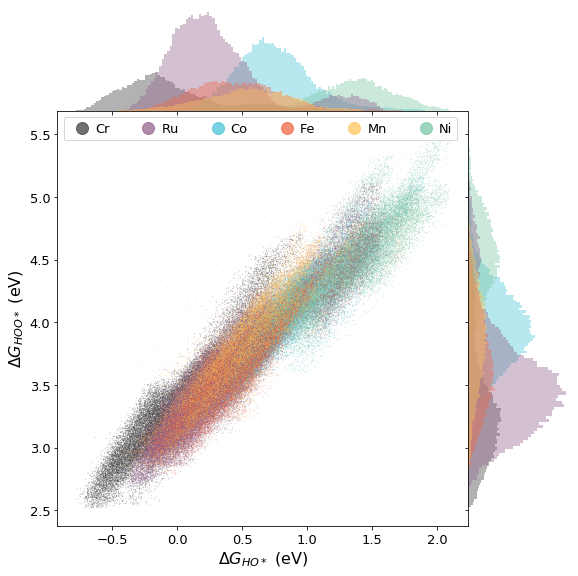

In [10]:
import matplotlib.patches as mpatches

c = [ mpatches.Circle((0.5, 0.5), 1, facecolor=ele2color[i], linewidth=3, label=i) for i in metals]

# custom_lgd = [
#     Circle((0.5, 0.5), 1, label='Co', color='#4CC3D9'),
#     Circle((0.5, 0.5), 1,label='Fe', color='#F16745'),
#     Circle((0.5, 0.5), 1,label='Ru', color='#93648D'),
#     Circle((0.5, 0.5), 1,label='Ni', color='#7BC8A4'),
#     Circle((0.5, 0.5), 1,label='Mn', color='#FFC65D'),
#     Circle((0.5, 0.5), 1,label='Cr', color='#404040'),

# ]
custom_lgd = [
    Line2D(range(1), range(1),label='Cr',marker='o', color='#404040', lw=0, markersize=12, alpha=0.75),
    Line2D(range(1), range(1),label='Ru',marker='o', color='#93648D', lw=0, markersize=12,alpha=0.75),
    Line2D(range(1), range(1), label='Co',marker='o', color='#4CC3D9', lw=0, markersize=12,alpha=0.75),
    Line2D(range(1), range(1),label='Fe',marker='o', color='#F16745', lw=0, markersize=12,alpha=0.75),
    Line2D(range(1), range(1),label='Mn',marker='o', color='#FFC65D', lw=0, markersize=12,alpha=0.75),
    Line2D(range(1), range(1),label='Ni',marker='o', color='#7BC8A4', lw=0, markersize=12,alpha=0.75),


]

def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.005, scatter_size=0.25):
    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            kwargs['s'] = scatter_size
            kwargs['label'] = label2metal[c]
            plt.scatter(*args, **kwargs)
            plt.ylabel("$\Delta{G_{HOO*}}$ (eV)", fontsize=15)
            plt.xlabel("$\Delta{G_{HO*}}$ (eV)", fontsize=15)
            plt.xticks(fontsize=13)
            plt.yticks(fontsize=13)

        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df,
        height=8, ratio=4, space=0.
    )
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=color,
            norm_hist=False, 
            kde=False,
            bins=100
        )
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,            
            vertical=True,
            norm_hist=False,
            kde=False, 
            bins=100
        )
    #plt.legend(c, metals,ncol=6, handler_map={mpatches.Circle: HandlerEllipse()}, fontsize=18).get_frame().set_facecolor('#F1F7EE')
    plt.legend(handles=custom_lgd, fontsize=13, ncol=6, handletextpad=0.0000001, loc='upper left')
    
import pandas as pd

cr_df = pd.DataFrame()
ru_df = pd.DataFrame()

cr_df['$\Delta{G_{HO*}}$ (eV)'] = metal_to_x_vec['Cr']
cr_df['$\Delta{G_{HOO*}}$ (eV)'] = metal_to_y_vec['Cr']
cr_df['metal'] = '#404040'
ru_df['$\Delta{G_{HO*}}$ (eV)'] = metal_to_x_vec['Ru']
ru_df['$\Delta{G_{HOO*}}$ (eV)'] = metal_to_y_vec['Ru']
ru_df['metal'] = '#93648D'

together_df = cr_df.append(ru_df).append(pd.DataFrame({
    "$\Delta{G_{HO*}}$ (eV)": metal_to_x_vec['Fe'],
    "$\Delta{G_{HOO*}}$ (eV)": metal_to_y_vec['Fe'],
    "metal": "#F16745"
})).append(pd.DataFrame({
    "$\Delta{G_{HO*}}$ (eV)": metal_to_x_vec['Ni'],
    "$\Delta{G_{HOO*}}$ (eV)": metal_to_y_vec['Ni'],
    "metal": "#7BC8A4"}
)).append(pd.DataFrame({
    "$\Delta{G_{HO*}}$ (eV)": metal_to_x_vec['Co'],
    "$\Delta{G_{HOO*}}$ (eV)": metal_to_y_vec['Co'],
    "metal": "#4CC3D9"}
)).append(pd.DataFrame({
    "$\Delta{G_{HO*}}$ (eV)": metal_to_x_vec['Mn'],
    "$\Delta{G_{HOO*}}$ (eV)": metal_to_y_vec['Mn'],
    "metal": "#FFC65D"
}))


image = multivariateGrid('$\Delta{G_{HO*}}$ (eV)', '$\Delta{G_{HOO*}}$ (eV)', 'metal', df=together_df,
                 k_is_color=True, scatter_alpha=.75, scatter_size=0.01)
plt.xlabel("$\Delta{G_{HO*}}$ (eV)", fontsize=16)
plt.ylabel("$\Delta{G_{HOO*}}$ (eV)", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig("alltogether.pdf")
plt.savefig("alltogether.png", dpi=800)

LinregressResult(slope=0.9462764901038713, intercept=3.270628412352214, rvalue=0.9475719748943991, pvalue=0.0, stderr=0.0007399122423916313)


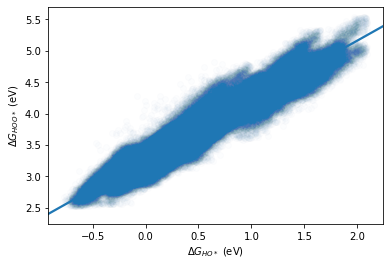

In [11]:
from scipy.stats import linregress
sns.regplot(together_df["$\Delta{G_{HO*}}$ (eV)"], together_df["$\Delta{G_{HOO*}}$ (eV)"], 
            scatter_kws={'alpha': 0.01})
print(linregress(together_df["$\Delta{G_{HO*}}$ (eV)"], together_df["$\Delta{G_{HOO*}}$ (eV)"]))

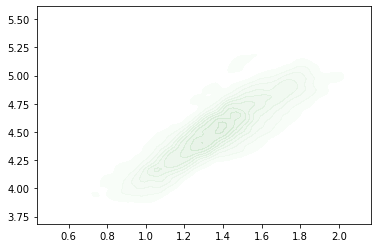

In [12]:
import seaborn as sns

sns.kdeplot(metal_to_x_vec["Ni"], metal_to_y_vec["Ni"], color='g', 
            shade=True, bw=0.025, shade_lowest=False, alpha=0.1)

LinregressResult(slope=1.1507449683095587, intercept=3.398833413550901, rvalue=0.9453110728259322, pvalue=0.0, stderr=0.002618204326434861)


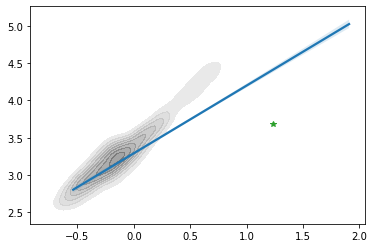

LinregressResult(slope=1.0768082604559217, intercept=3.280505888021638, rvalue=0.8993172602044833, pvalue=0.0, stderr=0.004139700040021937)


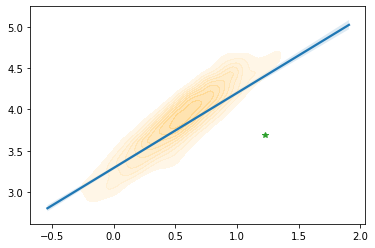

LinregressResult(slope=1.0258477453922505, intercept=3.2061024652225214, rvalue=0.9038372886940186, pvalue=0.0, stderr=0.0033513667164328316)


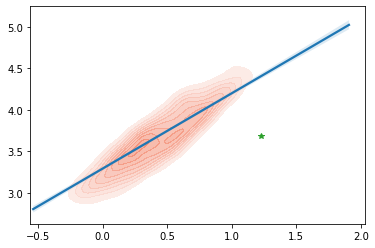

LinregressResult(slope=1.0149629155177984, intercept=3.2021820824623224, rvalue=0.9083721603921752, pvalue=0.0, stderr=0.002253240199539177)


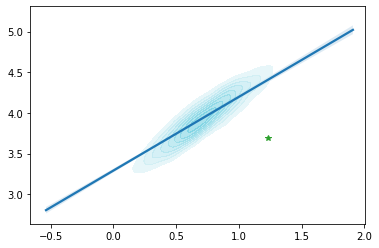

LinregressResult(slope=0.9716031732600721, intercept=3.191578121315483, rvalue=0.8418457126349536, pvalue=0.0, stderr=0.004021017878833492)


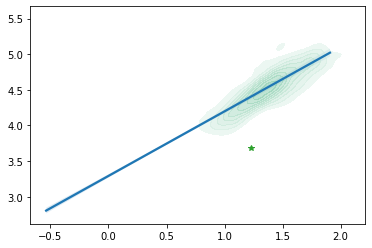

LinregressResult(slope=1.0349254587456653, intercept=3.215853887488386, rvalue=0.9334857091614617, pvalue=0.0, stderr=0.0016368569165984485)


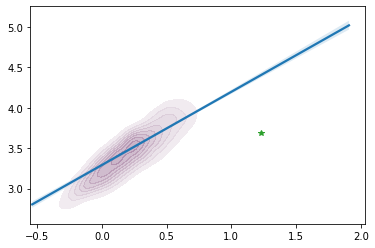

In [13]:
from scipy.stats import linregress
metals = ['Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Ru']
for m in metals:
    sns.regplot(oh_values, ooh_values, scatter_kws={'color':'w'})
    
    sns.kdeplot(metal_to_x_vec[m], metal_to_y_vec[m], color=ele2color[m], shade=True, label=m,
                 shade_lowest=False, alpha=0.5)
    plt.plot(1.23, 3.69, marker='*')
    ax.legend(handles=custom_lgd, fontsize=18)
    #plt.xlabel("$\Delta{G_{HO*}}$")
    plt.savefig("beef_data_{}.pdf".format(m))
    print(linregress(metal_to_x_vec[m], metal_to_y_vec[m]))
    plt.show()

In [14]:
from scipy.stats import linregress
print(linregress(oh_values, ooh_values))

LinregressResult(slope=0.9067205024327719, intercept=3.29179935419211, rvalue=0.9669314754817905, pvalue=3.964199323667096e-111, stderr=0.017630752575072475)
